In [ ]:
# the purpose of this notebook is to train either SVM or Random Forest models on warbleR features
# of vocalizations annotated in the notebook annotations_from_umap.ipynb

# preliminaries

## source the functions

In [1]:
%run '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/notebooks/00_manuscript/paths.py'
%run '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/notebooks/00_manuscript/utilities.py'
%run '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/notebooks/00_manuscript/spectrogramming.py'
%run '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/notebooks/00_manuscript/segmentation.py'

## define the paths

In [2]:
#root directory for the warbleR features for each species
amplitude_acoustic_features = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/development/20220913_063001/'

#root directory for the amplitude segmented developmental time course warbleR features
segments_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/development/20220913_063001/'

#root directory for the annotated vocalizations for each species
annotations_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/das/annotations_from_umap/'

#path to all warbleR features
warbleR_features = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented/20220913_063001/'

#annotated cries, whistles, and scratches from March 2022 (can use this to get scratch sounds)
annotations_20220321 = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/audio/annotated/for_ML_models/annotations_20220321/warbleR_stats/ground_truth_with_ccs.csv'


## choose features

In [3]:
# choose the features

#summary statistics of distributions of vocalization in time and frequency domain
base_features = [ 'duration',
                 'time.median', 
                 'time.Q25', 
                 'time.Q75', 
                 'time.IQR', 
                 'meanfreq', 
                 'freq.median', 
                 'freq.Q25', 
                 'freq.Q75', 
                 'freq.IQR', ]

#additional features calculated by warbleR
extra_features = ['meanpeakf', 
                  'dfslope', 
                  'enddom', 
                  'startdom', 
                  'modindx', 
                  'dfrange', 
                  'sfm', 
                  'entropy',  
                  'sp.ent', 
                  'time.ent', 
                  'sd',                  
                  'meandom', 
                  'mindom', 
                  'maxdom', 
                  'skew', 
                  'kurt']

#weight normalized features
all_features = base_features+extra_features
wn_features = [i+'_weight_normalized' for i in all_features]

# prepare data

## get the warbleR features for all vocalizations

In [4]:
#do this if you haven't combined anything yet

#get the features
to_combine = []

for i in [i for i in os.listdir(amplitude_acoustic_features) if 'warbler_features.csv' in i]:
    temp = pd.read_csv(amplitude_acoustic_features+i)
    to_combine.append(temp)
warbleR_features = pd.concat(to_combine)

#drop Mus and add usefule info
warbleR_features['species'] = [i.split('_')[0] for i in warbleR_features['source_file']]
warbleR_features = warbleR_features.loc[~warbleR_features['species'].isin(['MU', 'MZ'])]
#TODO figure out why this is in here (5 rows) ad remove it from whichever directory its contaminating
warbleR_features = warbleR_features.loc[warbleR_features['source_file'] != 'BW_hdbscan_label0_withspace.wav.wav']

#add weight
warbleR_features['weight_mg'] = [i.split('_')[5] for i in warbleR_features['source_file']]


In [144]:
len(nonvocal_df_scratch)

1242

In [111]:
# # or load something you already have

# #directory with all the features, one per dataset subdirectory
# features_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/features/acoustic_features/amplitude_segmented'

# #paths for the directory containing warbleR features for each dataset
# development_features_dir = os.path.join(features_root, 'development','20220913_063001')
# all_features_with_weight_normalization = 'all_species_warbler_features_labeled_weight_normalized.csv'

# #all features with columns for weight normalization
# wn_warbleR_features = pd.read_csv(os.path.join(development_features_dir, all_features_with_weight_normalization))

## collect the annotated files and their labels

In [5]:
species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
annotated_files = []

for species in species_list:
    print(species)
    
    #get the label_0 files
    label_0_voc_path = os.path.join(annotations_root,species,'annotations','hdbscan_label_0',species+'_hdbscan_label0_all.feather')
    
    #load the data
    label_0_voc_df = pd.read_feather(label_0_voc_path)
    
    #drop the spectrogram pixels and append
    label_0_voc_df = label_0_voc_df[['source_file', 'umap1', 'umap2', 'hdbscan_label', 'human_label']]
    annotated_files.append(label_0_voc_df)

    #get the label_1 files 
    label_1_voc_path = os.path.join(annotations_root,species,'annotations','hdbscan_label_1',species+'_hdbscan_label1_all.feather')
    
    #load the data
    label_1_voc_df = pd.read_feather(label_1_voc_path)
    
    #drop the spectrogram pixels and append
    label_1_voc_df = label_1_voc_df[['source_file', 'umap1', 'umap2', 'hdbscan_label', 'human_label']]
    annotated_files.append(label_1_voc_df)

print('combining files...')
all_combined = pd.concat(annotated_files)
all_combined['species'] = [i.split('_')[0] for i in all_combined['source_file']]
all_combined = all_combined.loc[~all_combined['human_label'].isin(['scratch', 'none'])]
all_combined = all_combined.reset_index(drop=True)

print('done.')
    

BW
BK
NB
SW
PO
LO
GO
LL
combining files...
done.


In [6]:
#get the warbleR features for these labeled vocalizations
warbleR_features = warbleR_features.drop(columns=['species'])
labeled_warbleR_features = all_combined.merge(warbleR_features, on='source_file')

In [7]:
for i in labeled_warbleR_features:
    if 'x' in i:
        print(i)
    if 'y' in i:
        print(i)

entropy
maxdom
modindx


In [8]:
#combine with current voc annotations
#assert sorted(labeled_warbleR_features.columns) == sorted(nonvocal_df.columns) #this will not be true if you are using weight normalized features
#all_annotations = pd.concat([labeled_warbleR_features,nonvocal_df])

all_annotations = labeled_warbleR_features.reset_index(drop=True)
print('labels:')
print(all_annotations['human_label'].unique())

labels:
['whistle' 'cry']


In [9]:
#make sure there are no bad pups in the training data

#bad pups are those with a lot fo artefacts (big vertical lines) identified during annotations for das
bad_pups = ['NB_28306x26626_ltr1_pup4_ch5_5000_m_334_300_fr0_p11_2021-10-04_10-04-13',
            'SW_29542x30031_ltr1_pup7_ch8_1600_m_348_263_fr0_p1_2022-01-05_10-54-58',
            'BK_26464x25680_ltr4_pup7_ch8_4500_f_355_318_fr0_p7_2021-11-24_09-42-41',
            'BK_26464x25680_ltr3_pup4_ch5_5100_m_351_326_fr0_p7_2021-10-31_11-18-39',
            'GO_24860x23748_ltr2_pup4_ch5_4700_m_324_292_fr0_p9_2021-10-02_12-35-01',
            'GO_23883x23084_ltr2_pup4_ch6_6100_f_329_304_fr0_p11_2019-12-03_10-35-37']

#drop them
all_annotations['pup'] = [i.split('_clip')[0] for i in all_annotations['source_file']]
print('dropping', len(all_annotations.loc[all_annotations['pup'].isin(bad_pups)]), 'vocs because they come from bad recordings...')
all_annotations = all_annotations.loc[~all_annotations['pup'].isin(bad_pups)]
assert len(all_annotations.loc[all_annotations['pup'].isin(bad_pups)]) == 0
print('done.')


dropping 220 vocs because they come from bad recordings...
done.


In [11]:
#print the number of annotations for each species and label

print('total label counts:\n\t')
print('cry:', len(all_annotations.loc[all_annotations['human_label'] == 'cry']))
print('whistle:', len(all_annotations.loc[all_annotations['human_label'] == 'whistle']))
print('scratch:', len(all_annotations.loc[all_annotations['human_label'] == 'scratch']))

print('\n')
for species in species_list:
    print(species)
    print('\tcry:', len(all_annotations.loc[all_annotations['human_label'] == 'cry'].loc[all_annotations['species'] == species]))
    print('\twhistle:', len(all_annotations.loc[all_annotations['human_label'] == 'whistle'].loc[all_annotations['species'] == species]))
    print('\tscratch:', len(all_annotations.loc[all_annotations['human_label'] == 'scratch'].loc[all_annotations['species'] == species]))
    print('\ttotal:', len(all_annotations.loc[all_annotations['human_label'] == 'cry'].loc[all_annotations['species'] == species])+len(all_annotations.loc[all_annotations['human_label'] == 'whistle'].loc[all_annotations['species'] == species]))
    

total label counts:
	
cry: 37430
whistle: 78920
scratch: 0


BW
	cry: 4734
	whistle: 13730
	scratch: 0
	total: 18464
BK
	cry: 5194
	whistle: 10574
	scratch: 0
	total: 15768
NB
	cry: 4542
	whistle: 9832
	scratch: 0
	total: 14374
SW
	cry: 4824
	whistle: 8608
	scratch: 0
	total: 13432
PO
	cry: 5198
	whistle: 6130
	scratch: 0
	total: 11328
LO
	cry: 4076
	whistle: 4678
	scratch: 0
	total: 8754
GO
	cry: 4678
	whistle: 13320
	scratch: 0
	total: 17998
LL
	cry: 4184
	whistle: 12048
	scratch: 0
	total: 16232


In [ ]:
# train a model to predict vocalization type

## downsamlpe

In [154]:
seed = 123456
num_to_sampled = 2000
downsampled_list = []

for species in species_list:
    
    print(species)

    #get the voc types for this label
    temp_cry = all_annotations.loc[all_annotations['species'] == species].loc[all_annotations['human_label'] == 'cry']
    temp_whistle = all_annotations.loc[all_annotations['species'] == species].loc[all_annotations['human_label'] == 'whistle']
   
    #sample
    temp_cry = temp_cry.sample(n=num_to_sampled, random_state = seed)
    temp_whistle = temp_whistle.sample(n=num_to_sampled, random_state = seed)
    
    #reasemble
    downsampled_species = pd.concat([temp_cry, temp_whistle])

    #update downsampled_list
    downsampled_list.append(downsampled_species)
    
#assemble all the species
ds_df = pd.concat(downsampled_list)



BW
BK
NB
SW
PO
LO
GO
LL


In [155]:
#get the previously annoatted scratch sounds
nonvocal_df = pd.read_csv(annotations_20220321)
nonvocal_df['human_label'] = [i.split('_')[0] for i in nonvocal_df['source_file']]
nonvocal_df_scratch = nonvocal_df.loc[nonvocal_df['human_label'] == 'scratch']
nonvocal_df_scratch['species'] = [i.split('_')[1] for i in nonvocal_df_scratch['source_file']]
nonvocal_df_scratch = nonvocal_df_scratch[base_features+extra_features+['source_file','species', 'human_label']]

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [156]:
ds_df = ds_df.drop(columns = ['umap1', 'umap2', 'hdbscan_label', 'pup', 'genus_color', 'weight_mg', 'species_color'])

In [158]:
assert sorted(nonvocal_df_scratch.columns) == sorted(ds_df.columns)

In [159]:
#add the human labeled non_vocal sounds ("scratch")
ds_df = pd.concat([ds_df, nonvocal_df_scratch])

In [160]:
ds_df = ds_df.dropna(subset=['human_label'])

In [161]:
print('annotations by species:\n')
for i in species_list:
    print(i,':', len(ds_df.loc[ds_df['species'] == i]))

annotations by species:

BW : 4317
BK : 4022
NB : 4047
SW : 4012
PO : 4213
LO : 4061
GO : 4308
LL : 4254


In [162]:
print('annotations by label:\n')
print('cry:', len(ds_df.loc[ds_df['human_label'] == 'cry']))
print('whistle:', len(ds_df.loc[ds_df['human_label'] == 'whistle']))
print('scratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch']))

annotations by label:

cry: 16000
whistle: 16000
scratch: 1242


## select the features

In [163]:
df = ds_df[base_features+extra_features]

In [164]:
ds_df['human_label'].unique()

array(['cry', 'whistle', 'scratch'], dtype=object)

## check for missing data

In [165]:
if df.isnull().values.any() == True:
    print('There are', df.isnull().sum().sum(), 'missing data')
    #if there are missing data, replace them by the mean of the rest of the data from the column they come from 
    #all data are numeric in the current features data set, but if ever there are categorical features these should be excluded here

    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer.fit(df)
    df = imputer.transform(df)
    print('imputed missing data using SimpleImputer...')
    
else: 
    print('No missing data')
    


No missing data


## choose the model type and split the data

In [166]:
#Split the test data from the train data - do this before scaling! Scaling before splitting 
#will result in information leakage between train and test data sets

#Typical split is 80% train 20% test

random_state = 123456
test_size = 0.2
model_type = 'random_forest'
assert model_type in ['random_forest', 'svm']

#import packages
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#choose the data and the label and convert to numpy array

X = np.array(df)
y = np.array(ds_df['human_label'])

#split the data
print('splitting the data...')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

#transform and scale the data - don't do this for random forest
if model_type == 'svm':
    'scaling data for svm...'
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
print('done.')

splitting the data...
done.


## train

In [167]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

random_state = 123456
if model_type == 'random_forest':
    
    n_estimators = 10000
    criterion = 'entropy'
    
    RF_model = RandomForestClassifier(n_estimators = n_estimators, 
                                      criterion = 'entropy', 
                                      random_state = random_state, 
                                      oob_score=True)
    RF_model.fit(X_train, y_train)

    print(RF_model.oob_score_)

    #RF_scores = cross_val_score(estimator = RF_model, X = X_train, y = y_train, cv=10) #10 is the most common number of folds
    #print("%0.2f accuracy with a standard deviation of %0.2f" % (RF_scores.mean(), RF_scores.std()))
    
elif model_type == 'svm':
    
    kernel = 'rbf'

    SVM_model = SVC(kernel=kernel, 
                    random_state = random_state)
    SVM_model.fit(X_train, y_train)

    SVM_scores = cross_val_score(estimator = SVM_model, X = X_train, y = y_train, cv=10) #10 is the most common number of folds
    print("%0.2f accuracy with a standard deviation of %0.2f" % (SVM_scores.mean(), SVM_scores.std()))
    

0.9962020080472305


## evaluate

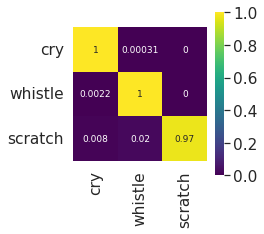

In [168]:
#Evaluate the model on held out data
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score

save = False

###################################################################################################################

#Evaluate the model on held out data
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
import matplotlib as mpl

#choose the model to evaluate
voc_type_model_path = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20220921_061801/random_forest_20220921_061801_model.pkl'
RF_model = pickle.load(open(voc_type_model_path, 'rb'))
model = RF_model

#set the colorbar range
# vmin=0
# vmax=1
# ax1, _ = mpl.colorbar.make_axes(plt.gca(), shrink=0.5)
# cbar = mpl.colorbar.ColorbarBase(ax1, cmap='viridis', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
#pcm = ax.pcolormesh(x, y, Z, vmin=0, vmax=1., cmap='viridis')

y_pred = model.predict(X_test)
labels = ['cry', 'whistle', 'scratch']
cm = confusion_matrix(y_test,y_pred, labels = labels)
fig = plt.figure(figsize=[3,3])

#normalize by row sum
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, 
            annot=True, 
            annot_kws={"size": 9}, 
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True) # font size

classification_report(y_test, y_pred, output_dict=True)

if save:
    plt.savefig('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/panels/voctype_RF_20221015.jpeg', dpi=600)
    plt.savefig('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/panels/voctype_RF_20221015.svg') 

In [170]:
classification_report(y_test, y_pred, output_dict=True)

{'cry': {'precision': 0.9971777986829727,
  'recall': 0.9996856334486011,
  'f1-score': 0.998430141287284,
  'support': 3181},
 'scratch': {'precision': 1.0,
  'recall': 0.9721115537848606,
  'f1-score': 0.9858585858585859,
  'support': 251},
 'whistle': {'precision': 0.9981343283582089,
  'recall': 0.9978240596829344,
  'f1-score': 0.9979791699051764,
  'support': 3217},
 'accuracy': 0.9977440216573921,
 'macro avg': {'precision': 0.9984373756803939,
  'recall': 0.989873748972132,
  'f1-score': 0.9940892990170155,
  'support': 6649},
 'weighted avg': {'precision': 0.9977471367030973,
  'recall': 0.9977440216573921,
  'f1-score': 0.9977373701414209,
  'support': 6649}}

## save the model

In [169]:
# write model params

if model_type == 'random_forest':
    
    model_params = {'model_type':model_type,
                    'feature_set':list(base_features+extra_features),
                    'targets': list(ds_df['human_label'].unique()),
                    'test_size':test_size,
                    'number_training_cries':len(ds_df.loc[ds_df['human_label']=='cry']),
                    'number_training_whistles':len(ds_df.loc[ds_df['human_label']=='whistle']),
                    'number_training_nonvocal':len(ds_df.loc[ds_df['human_label']=='scratch']),
                    'n_estimators':n_estimators,
                    'criterion':criterion,
                    'random_state':random_state}         
    
    if model_params['targets'] == ['cry', 'whistle', 'scratch']:
        target_dir = 'voc_type_classifiers'
        models_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/'
        iteration = get_date_time()
        params_save_name = ('_').join([model_type,iteration,'params'])
        params_save_dir = os.path.join(models_root,target_dir,iteration)+'/'

        if iteration not in os.listdir(os.path.join(models_root,target_dir)):
            os.mkdir(params_save_dir)
            print('made a directory:\n\t', params_save_dir)

        #save the parameters
        save_parameters(params = model_params,
                        save_dir=params_save_dir, 
                        save_name=params_save_name)

        #save the model
        model_save_name = ('_').join([model_type,iteration,'voc_type_model'])                               
        pickle.dump(RF_model, open(os.path.join(params_save_dir,model_save_name)+'.pkl', 'wb'))
        assert os.path.exists(os.path.join(params_save_dir,model_save_name)+'.pkl')
        print('saved model to:\n\t', os.path.join(params_save_dir,model_save_name)+'.pkl')
        print('done.')

    elif 'BW' in model_params['targets']:
        target_dir = 'species_classifiers'
        models_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/'
        iteration = get_date_time()
        params_save_name = ('_').join([model_type,iteration,'params'])
        params_save_dir = os.path.join(models_root,target_dir,iteration)+'/'

        if iteration not in os.listdir(os.path.join(models_root,target_dir)):
            os.mkdir(params_save_dir)
            print('made a directory:\n\t', params_save_dir)

        #save the parameters
        save_parameters(params = model_params,
                        save_dir=params_save_dir, 
                        save_name=params_save_name)

        #save the model
        model_save_name = ('_').join([model_type,iteration,'model'])                               
        pickle.dump(RF_model, open(os.path.join(params_save_dir,model_save_name)+'.pkl', 'wb'))
        assert os.path.exists(os.path.join(params_save_dir,model_save_name)+'.pkl')
        print('saved model to:\n\t', os.path.join(params_save_dir,model_save_name)+'.pkl')
        print('done.')
                        
                        

#TODO finish this
elif model_type == 'svm':
    model_params = {'model_type':model_type,
                    'feature_set':'warbleR',
                    'test_size':test_size,
                    'targets': df_df['human_label'].unique(),
                    'number_training_cries':len(ds_df.loc[ds_df['human_label'=='cry']]),
                    'number_training_whistles':len(ds_df.loc[ds_df['human_label'=='whistle']]),
                    'number_training_nonvocal':len(ds_df.loc[ds_df['human_label'=='scratch']]),
                    'kernel':kernel,
                    'random_state':random_state}
        


made a directory:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20221019_045423/
making a new params file...
saved the params file to:
 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20221019_045423/random_forest_20221019_045423_params
saved model to:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/voc_type_classifiers/20221019_045423/random_forest_20221019_045423_voc_type_model.pkl
done.


# train a model to predict species from a given vocalization type

## summary of annotated vocalizations

In [226]:
#print the number of annotations for each species and label

print('total label counts:\n\t')
print('cry:', len(all_annotations.loc[all_annotations['human_label'] == 'cry']))
print('whistle:', len(all_annotations.loc[all_annotations['human_label'] == 'whistle']))
print('scratch:', len(all_annotations.loc[all_annotations['human_label'] == 'scratch']))

print('\n')
for species in species_list:
    print(species)
    print('\tcry:', len(all_annotations.loc[all_annotations['human_label'] == 'cry'].loc[all_annotations['species'] == species]))
    print('\twhistle:', len(all_annotations.loc[all_annotations['human_label'] == 'whistle'].loc[all_annotations['species'] == species]))
    print('\tscratch:', len(all_annotations.loc[all_annotations['human_label'] == 'scratch'].loc[all_annotations['species'] == species]))
          

total label counts:
	
cry: 37430
whistle: 78920
scratch: 0


BW
	cry: 4734
	whistle: 13730
	scratch: 0
BK
	cry: 5194
	whistle: 10574
	scratch: 0
NB
	cry: 4542
	whistle: 9832
	scratch: 0
SW
	cry: 4824
	whistle: 8608
	scratch: 0
PO
	cry: 5198
	whistle: 6130
	scratch: 0
LO
	cry: 4076
	whistle: 4678
	scratch: 0
GO
	cry: 4678
	whistle: 13320
	scratch: 0
LL
	cry: 4184
	whistle: 12048
	scratch: 0


In [227]:
len([i for i in all_annotations['weight_mg'] if i=='nan'])

2508

## downsample

In [392]:
seed = 123456
num_to_sampled = 2000

downsampled_list = []

#drop pups that don't have weight info
#all_annotations = all_annotations.loc[all_annotations['weight_mg'] != 'nan']

for species in species_list:

    #get the voc types for this label
    temp_cry = all_annotations.loc[all_annotations['species'] == species].loc[all_annotations['human_label'] == 'cry']
    #temp_whistle = all_annotations.loc[all_annotations['species'] == species].loc[all_annotations['human_label'] == 'whistle']
   
    #sample
    temp_cry = temp_cry.sample(n=num_to_sampled, random_state = seed)
    #temp_whistle = temp_whistle.sample(n=num_to_sampled, random_state = seed)
    
    #reasemble
    #downsampled_species = pd.concat([temp_cry, temp_whistle])
    downsampled_species = temp_cry
    #update downsampled_list
    downsampled_list.append(downsampled_species)
    
#assemble all the species
ds_df = pd.concat(downsampled_list)
ds_df = ds_df.reset_index(drop=True)

#show some useful info
print('annotations by species:\n')
for i in species_list:
    print(i,':', len(ds_df.loc[ds_df['species'] == i]))
    
print('annotations by label:\n')
print('cry:', len(ds_df.loc[ds_df['human_label'] == 'cry']))
print('whistle:', len(ds_df.loc[ds_df['human_label'] == 'whistle']))
print('scratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch']))



annotations by species:

BW : 2000
BK : 2000
NB : 2000
SW : 2000
PO : 2000
LO : 2000
GO : 2000
LL : 2000
annotations by label:

cry: 16000
whistle: 0
scratch: 0


In [393]:
#show some useful info
print('annotations by species:\n')
for i in species_list:
    print(i,':', len(ds_df.loc[ds_df['species'] == i]))
    
print('annotations by label:\n')
print('cry:', len(ds_df.loc[ds_df['human_label'] == 'cry']))
print('whistle:', len(ds_df.loc[ds_df['human_label'] == 'whistle']))
print('scratch:', len(ds_df.loc[ds_df['human_label'] == 'scratch']))

annotations by species:

BW : 2000
BK : 2000
NB : 2000
SW : 2000
PO : 2000
LO : 2000
GO : 2000
LL : 2000
annotations by label:

cry: 16000
whistle: 0
scratch: 0


In [230]:
# # load saved downsampling
# save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/for_R'
# save_name = 'downsampled_development_vocs.csv'

# ds_df = pd.read_csv(os.path.join(save_dir, save_name))

## train the model to predict species from a specific vocalization type

## select features

In [394]:
#choose voc_type if you want to normalize by weight or not
voc_type = 'cry'
features = ['duration', 'dfslope', 'time.median', 'time.IQR', 'time.Q25', 'time.Q75', 'meanfreq', 'meandom', 'freq.IQR', 'freq.Q25', 'freq.Q75', 'freq.median', 'sp.ent', 'time.ent']

voc_ds_df = ds_df.loc[ds_df['human_label'] == voc_type]
df = voc_ds_df[features]
    

In [1]:
voc_type = 'cry'
features = ['duration', 'dfslope', 'time.median', 'time.IQR', 'time.Q25', 'time.Q75', 'meanfreq', 'meandom', 'freq.IQR', 'freq.Q25', 'freq.Q75', 'freq.median', 'sp.ent', 'time.ent']



In [2]:
len(features)

14

## check for missing data

In [396]:
if df.isnull().values.any() == True:
    print('There are', df.isnull().sum().sum(), 'missing data')
    #if there are missing data, replace them by the mean of the rest of the data from the column they come from 
    #all data are numeric in the current features data set, but if ever there are categorical features these should be excluded here

    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer.fit(df)
    df = imputer.transform(df)
    print('imputed missing data using SimpleImputer...')
    
else: 
    print('No missing data')
    


No missing data


## choose the model type and split the data

In [397]:
#Split the test data from the train data - do this before scaling! Scaling before splitting 
#will result in information leakage between train and test data sets

model_type = 'random_forest'
assert model_type in ['random_forest', 'svm']

#Typical split is 80% train 20% test
random_state = 123456
test_size = 0.2

#import packages
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#choose the data and the label and convert to numpy array
target = 'species'
X = np.array(df)
y = np.array(voc_ds_df[target])

#split the data
print('splitting the data...')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

#transform and scale the data - don't do this for random forest
if model_type == 'svm':
    'scaling data for svm...'
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
print('done.')

splitting the data...
done.


## train

In [398]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

random_state = 123456
if model_type == 'random_forest':
    
    n_estimators = 500
    criterion = 'entropy'
    
    RF_model = RandomForestClassifier(n_estimators = n_estimators, 
                                      criterion = 'entropy', 
                                      random_state = random_state, 
                                      bootstrap = True,
                                      oob_score=True)
    RF_model.fit(X_train, y_train)

    print(RF_model.oob_score_)

    #RF_scores = cross_val_score(estimator = RF_model, X = X_train, y = y_train, cv=10) #10 is the most common number of folds
    #print("%0.2f accuracy with a standard deviation of %0.2f" % (RF_scores.mean(), RF_scores.std()))
    
elif model_type == 'svm':
    
    kernel = 'rbf'

    SVM_model = SVC(kernel=kernel, 
                    random_state = random_state)
    SVM_model.fit(X_train, y_train)

    SVM_scores = cross_val_score(estimator = SVM_model, X = X_train, y = y_train, cv=10) #10 is the most common number of folds
    print("%0.2f accuracy with a standard deviation of %0.2f" % (SVM_scores.mean(), SVM_scores.std()))
    

0.71234375


## evaluate

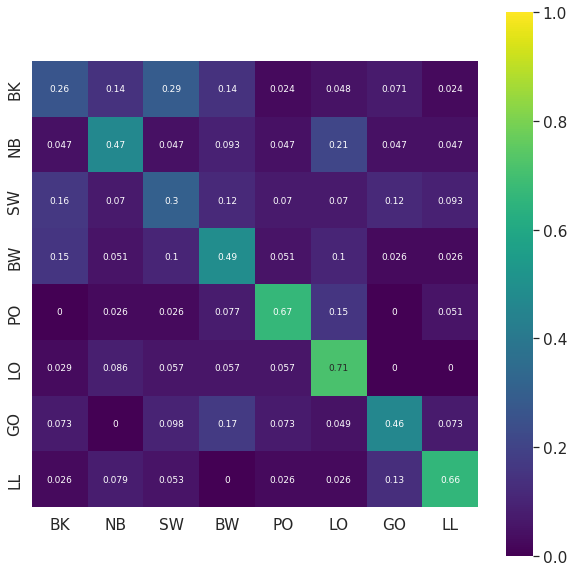

In [235]:

save = True

###################################################################################################################

#Evaluate the model on held out data
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
import matplotlib as mpl

#choose the model to evaluate
model = RF_model

#set the colorbar range
# vmin=0
# vmax=1
# ax1, _ = mpl.colorbar.make_axes(plt.gca(), shrink=0.5)
# cbar = mpl.colorbar.ColorbarBase(ax1, cmap='viridis', norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax))
#pcm = ax.pcolormesh(x, y, Z, vmin=0, vmax=1., cmap='viridis')

y_pred = model.predict(X_test)
labels = ['BK', 'NB', 'SW', 'BW', 'PO', 'LO', 'GO', 'LL']
cm = confusion_matrix(y_test,y_pred, labels = labels)
fig = plt.figure(figsize=[10,10])

#normalize by row sum
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
cm_df = cm_df.div(cm_df.sum(axis=1), axis=0)

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm_df, 
            annot=True, 
            annot_kws={"size": 9}, 
            cmap='viridis', 
            xticklabels=True, 
            yticklabels=True, 
            vmin=0, 
            vmax=1, 
            square=True) # font size

report = classification_report(y_test, y_pred, output_dict=True)

if save:
    plt.savefig('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'+voc_type+'_RF_1000_trees_20221012.jpeg', dpi=600)
    plt.savefig('/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'+voc_type+'_RF_1000_trees_20221012.pdf')


In [252]:
from sklearn.inspection import permutation_importance
importances_mean = list(permutation_importance(model, X_test, y_test)['importances_mean'])
importances_std = list(permutation_importance(model, X_test, y_test)['importances_std'])
importances = importances_mean + importances_std

In [253]:
importances_mean

array([ 0.00625 ,  0.00375 ,  0.008125,  0.00625 ,  0.000625,  0.01625 ,
        0.010625,  0.025625, -0.00625 ,  0.095625,  0.000625, -0.003125,
        0.023125, -0.01125 ])

In [240]:
model.feature_importances_

array([0.06614245, 0.06418943, 0.06685258, 0.06372119, 0.05746452,
       0.07461259, 0.07047062, 0.07549739, 0.06964803, 0.11177223,
       0.07677795, 0.0647553 , 0.07284388, 0.06525186])

Elapsed time to compute the importances: 0.295 seconds


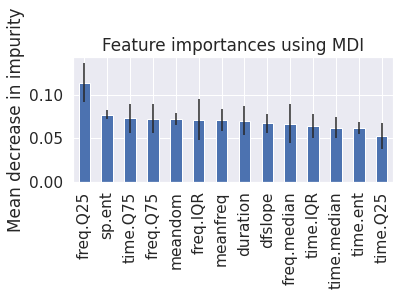

In [123]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import pandas as pd
import time
import numpy as np

feature_names = features
start_time = time.time()
importances = RF_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Elapsed time to compute the importances: 0.030 seconds


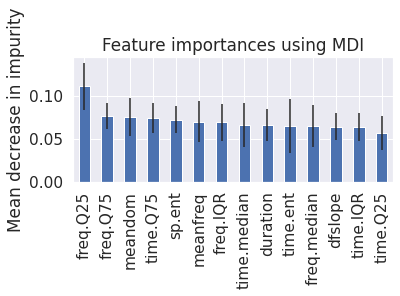

In [244]:
#https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
import pandas as pd
import time
import numpy as np

feature_names = features
start_time = time.time()
importances = RF_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## save the model

In [125]:
# write model params

training_df = voc_ds_df
if model_type == 'random_forest':
    
    model_params = {'model_type':model_type,
                    'feature_set':list(base_features+extra_features),
                    'targets': list(training_df['species'].unique()),
                    'test_size':test_size,
                    'number_training_cries':len(training_df.loc[training_df['human_label']=='cry']),
                    'number_training_whistles':len(training_df.loc[training_df['human_label']=='whistle']),
                    'number_training_nonvocal':len(training_df.loc[training_df['human_label']=='scratch']),
                    'n_estimators':n_estimators,
                    'criterion':criterion,
                    'random_state':random_state}         
    
    if model_params['targets'] == ['cry', 'whistle', 'scratch']:
        target_dir = 'voc_type_classifiers'
        models_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/'
        iteration = get_date_time()
        params_save_name = ('_').join([model_type,iteration,'voc_type_params'])
        params_save_dir = os.path.join(models_root,target_dir,iteration)+'/'

        if iteration not in os.listdir(os.path.join(models_root,target_dir)):
            os.mkdir(params_save_dir)
            print('made a directory:\n\t', params_save_dir)

        #save the parameters
        save_parameters(params = model_params,
                        save_dir=params_save_dir, 
                        save_name=params_save_name)

        #save the model
        model_save_name = ('_').join([model_type,iteration,'voc_type_model'])                               
        pickle.dump(RF_model, open(os.path.join(params_save_dir,model_save_name)+'.pkl', 'wb'))
        assert os.path.exists(os.path.join(params_save_dir,model_save_name)+'.pkl')
        print('saved model to:\n\t', os.path.join(params_save_dir,model_save_name)+'.pkl')
        print('done.')

    elif 'BW' in model_params['targets']:
        target_dir = 'species_classifiers'
        models_root = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/'
        iteration = get_date_time()
        params_save_name = ('_').join([model_type,iteration,'species_params', voc_type])
        params_save_dir = os.path.join(models_root,target_dir,iteration)+'/'

        if iteration not in os.listdir(os.path.join(models_root,target_dir)):
            os.mkdir(params_save_dir)
            print('made a directory:\n\t', params_save_dir)

        #save the parameters
        save_parameters(params = model_params,
                        save_dir=params_save_dir, 
                        save_name=params_save_name)

        #save the model
        model_save_name = ('_').join([model_type,iteration,'species_model', voc_type])                               
        pickle.dump(RF_model, open(os.path.join(params_save_dir,model_save_name)+'.pkl', 'wb'))
        assert os.path.exists(os.path.join(params_save_dir,model_save_name)+'.pkl')
        print('saved model to:\n\t', os.path.join(params_save_dir,model_save_name)+'.pkl')
        print('done.')
                        
                        

#TODO finish this
elif model_type == 'svm':
    model_params = {'model_type':model_type,
                    'feature_set':'warbleR',
                    'test_size':test_size,
                    'targets': df_df['human_label'].unique(),
                    'number_training_cries':len(ds_df.loc[ds_df['human_label'=='cry']]),
                    'number_training_whistles':len(ds_df.loc[ds_df['human_label'=='whistle']]),
                    'number_training_nonvocal':len(ds_df.loc[ds_df['human_label'=='scratch']]),
                    'kernel':kernel,
                    'random_state':random_state}
        


made a directory:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20221006_081440/
making a new params file...
saved the params file to:
 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20221006_081440/random_forest_20221006_081440_species_params_cry
saved model to:
	 /n/hoekstra_lab_tier1/Users/njourjine/manuscript/models/random_forest/species_classifiers/20221006_081440/random_forest_20221006_081440_species_model_cry.pkl
done.


# Linear Discriminant Analysis

In [370]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [371]:
#choose voc type and subset
voc_type = 'whistle'
voc_ds_df = ds_df.loc[ds_df['human_label'] == voc_type]
df = voc_ds_df[base_features+extra_features]

In [372]:
if df.isnull().values.any() == True:
    print('There are', df.isnull().sum().sum(), 'missing data')
    #if there are missing data, replace them by the mean of the rest of the data from the column they come from 
    #all data are numeric in the current features data set, but if ever there are categorical features these should be excluded here

    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
    imputer.fit(df)
    df = imputer.transform(df)
    print('imputed missing data using SimpleImputer...')
    
else: 
    print('No missing data')
    


No missing data


In [397]:
#Split the test data from the train data - do this before scaling! Scaling before splitting 
#will result in information leakage between train and test data sets

model_type = 'lda'
assert model_type in ['random_forest', 'svm', 'lda']

#Typical split is 80% train 20% test
random_state = 123456
test_size = 0.2

#import packages
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#choose the data and the label and convert to numpy array
target = 'species'
X = np.array(df)
y = np.array(cry_ds_df[target])

#split the data
print('splitting the data...')
X_train, X_test, y_train, y_test = train_test_split(df, cry_ds_df[target], test_size = test_size, random_state = random_state)

#transform and scale the data - don't do this for random forest
if model_type in ['svm', 'lda']:
    'scaling data for svm...'
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
print('done.')

splitting the data...
done.


In [400]:
df

,duration,time.median,time.Q25,time.Q75,time.IQR,meanfreq,freq.median,freq.Q25,freq.Q75,freq.IQR,...,sfm,entropy,sp.ent,time.ent,sd,meandom,mindom,maxdom,skew,kurt
6141,0.022528,0.011264,0.003755,0.018773,0.015019,62.646955,57.677515,44.896450,84.748521,39.852071,...,0.704884,0.790100,0.955665,0.826754,28.849605,54.646810,44.555664,65.063477,2.882206,13.854294
4263,0.016380,0.010920,0.005460,0.016380,0.010920,61.455865,52.365209,41.439471,85.752798,44.313327,...,0.738935,0.696369,0.957724,0.727109,30.537468,47.119141,41.137695,52.368164,3.741324,21.320656
796,0.030720,0.011520,0.007680,0.023040,0.015360,63.447978,60.980472,53.234337,69.930838,16.696501,...,0.591233,0.799599,0.932424,0.857548,24.500390,53.534614,40.405273,67.504883,2.778972,10.873369
5605,0.016384,0.008192,0.004096,0.012288,0.008192,67.868402,70.338078,61.370107,76.316726,14.946619,...,0.500341,0.680272,0.901140,0.754902,22.249601,71.594238,59.204102,77.514648,3.365053,16.043689
5,0.024576,0.012288,0.004096,0.020480,0.016384,62.822144,56.498305,44.945763,87.861017,42.915254,...,0.749717,0.800349,0.963135,0.830983,30.379400,51.077706,44.311523,63.598633,3.183965,16.444555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48647,0.016384,0.008192,0.004096,0.012288,0.008192,71.507940,78.207931,59.783935,86.016777,26.232842,...,0.557705,0.689441,0.929914,0.741403,24.731098,60.485840,7.690430,93.872070,2.997948,15.389322
46601,0.024576,0.016384,0.004096,0.020480,0.016384,101.720585,117.230508,94.694915,122.518644,27.823729,...,0.398922,0.692137,0.854462,0.810027,32.421849,119.890485,112.915039,124.633789,7.119667,72.619952
45428,0.020480,0.012288,0.012288,0.016384,0.004096,74.852880,74.178194,61.826688,88.238405,26.411717,...,0.335043,0.567203,0.916389,0.618954,18.866673,71.801758,60.180664,78.247070,1.992521,8.629987
49018,0.020480,0.008192,0.008192,0.008192,0.000000,72.380996,71.639544,68.905614,76.228641,7.323027,...,0.177836,0.456357,0.835878,0.545961,11.343239,72.957357,69.213867,79.223633,3.629761,16.870681


In [398]:
X_train

array([[ 0.91329024,  1.29016736,  0.60987367, ...,  0.50689423,
         0.21471902, -0.05735513],
       [-0.1095223 , -0.03132413, -0.07846196, ..., -1.26559232,
        -0.80143843, -0.45523752],
       [-0.62092857, -0.84939029, -0.73322024, ...,  0.93524514,
        -0.61416033, -0.45793474],
       ...,
       [-0.74878014, -0.71304593, -0.62409386, ..., -0.05439318,
         0.15944139, -0.08700338],
       [ 0.14618084,  0.48375456, -0.05421165, ..., -1.59054819,
         0.38530389,  0.08843914],
       [-0.62092857,  0.24136459,  0.1397908 , ...,  1.14203524,
        -0.52672628, -0.42235089]])

In [379]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

random_state = 123456
if model_type == 'random_forest':
    
    n_estimators = 10
    criterion = 'entropy'
    
    RF_model = RandomForestClassifier(n_estimators = n_estimators, 
                                      criterion = 'entropy', 
                                      random_state = random_state, 
                                      oob_score=True)
    RF_model.fit(X_train, y_train)

    print(RF_model.oob_score_)

    RF_scores = cross_val_score(estimator = RF_model, X = X_train, y = y_train, cv=10) #10 is the most common number of folds
    print("%0.2f accuracy with a standard deviation of %0.2f" % (RF_scores.mean(), RF_scores.std()))
    
elif model_type == 'svm':
    
    kernel = 'rbf'

    SVM_model = SVC(kernel=kernel, 
                    random_state = random_state)
    SVM_model.fit(X_train, y_train)

    SVM_scores = cross_val_score(estimator = SVM_model, X = X_train, y = y_train, cv=10) #10 is the most common number of folds
    print("%0.2f accuracy with a standard deviation of %0.2f" % (SVM_scores.mean(), SVM_scores.std()))

elif model_type == 'lda':
    LDA_model = LinearDiscriminantAnalysis()
    LDA_model.fit(X_train, y_train).transform(X_train)
    
    

In [390]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# define model
model = LDA_model
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# summarize result
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.445 (0.013)


In [392]:
def LDA_coefficients(X,lda):
    nb_col = X.shape[1]
    matrix= np.zeros((nb_col+1,nb_col), dtype=int)
    Z=pd.DataFrame(data=matrix,columns=X.columns)
    for j in range(0,nb_col):
        Z.iloc[j,j] = 1
    LD = lda.transform(Z)
    nb_funct= LD.shape[1]
    results = pd.DataFrame();
    index = ['const']
    for j in range(0,LD.shape[0]-1):
        index = np.append(index,'C'+str(j+1))
    for i in range(0,LD.shape[1]):
        coef = [LD[-1][i]]
        for j in range(0,LD.shape[0]-1):
            coef = np.append(coef,LD[j][i]-LD[-1][i])
        result = pd.Series(coef)
        result.index = index
        column_name = 'LD' + str(i+1)
        results[column_name] = result
    return results

In [394]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)

results = LDA_coefficients(df,lda)


/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [396]:
results = results.sort_values(by='LD1')
results

,LD1,LD2,LD3,LD4,LD5,LD6,LD7
C18,-5.193597e-01,7.417929e-01,3.181770e+00,3.426026e-01,2.168447e+00,-1.115490e+01,5.593573e+00
C9,-4.139742e-01,-6.229924e-01,-5.133859e-01,8.872871e-01,-7.153753e-01,-1.336485e-01,-1.283383e+00
C2,-2.686292e-01,-1.176029e-01,-2.578738e-01,-2.686893e-01,-1.771185e-01,9.892482e-01,-2.188356e-01
C19,-2.638964e-01,-1.251926e+00,-1.592142e+00,3.363422e-01,-1.285996e+00,4.801220e+00,-1.494068e+00
C10,-2.575283e-01,-1.435900e-01,1.647031e-01,1.558264e-01,2.828882e-01,2.210380e-01,-4.185746e-01
C13,-2.118353e-01,5.941002e-02,1.225192e-01,-8.070749e-02,3.498251e-02,-3.304125e-01,6.927975e-01
C15,-1.937138e-01,-1.796787e-01,-1.063541e-01,3.250613e-01,2.780206e-01,-2.379661e-01,2.050059e-01
C3,-1.115180e-01,-4.925872e-02,7.430054e-02,8.646165e-02,2.351095e-01,1.749662e-01,-1.648436e-01
C7,-1.055762e-01,-9.995161e-01,-2.056307e+00,1.358652e-01,-5.398699e-01,-2.979979e-01,5.803159e-01
C25,-8.217822e-02,-4.021768e-01,-7.896570e-01,4.007724e-01,-4.130708e-01,-3.658232e-01,-5.213043e-01


In [387]:
test = plot_confusion_matrix(LDA_model, X_test, y_test, normalize = 'pred', values_format = None,ax = ax1) 

/n/home10/jourjine/.conda/envs/manuscript/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


# compare models trained on different amounts of data

In [277]:
## train multiple models on different numbers of vocalizations

#import packages
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.inspection import permutation_importance

def get_metric_by_sample_size(model_type, voc_type, voc_df, sample_sizes, features, seed, test_size, target ='species', n_trees = 500):
    #get the vocalizations that belong to voc_type
    all_annotations = voc_df.loc[voc_df['human_label'] == voc_type]
        
    # train multiple models on different numbers of vocalizations
    all_scores = []
    all_importances = []
    
    #downsample
    all_downsampled = []
    for sample_n in sample_sizes:
        
        print('training', model_type, 'on', sample_n, 'vocalizations.')
        
        #sample equally for each species
        print('\tsampling data...')
        downsampled_list = []
        species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
        for species in species_list:

            #get the vocs for this species
            temp= all_annotations.loc[all_annotations['species'] == species]

            #sample
            temp = temp.sample(n=sample_n, random_state = seed)

            #update downsampled_list
            downsampled_list.append(temp)

        #assemble all the species
        ds_df = pd.concat(downsampled_list)
        ds_df = ds_df.reset_index(drop=True)
        
        #select the features
        ds_df = ds_df[features+[target]]

        #assert there are no missing data
        assert df.isnull().values.any() == False, "There are missing data"

        #split the train/test
        #choose the data and the label and convert to numpy array
        X = np.array(ds_df.drop(columns=[target]))
        y = np.array(ds_df[target])

        #split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

        #transform and scale the data - don't do this for random forest
        if model_type != 'random_forest':
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)

        #train the model
        print('\ttraining model...')
        if model_type == 'random_forest':

            model = RandomForestClassifier(n_estimators = n_estimators,  
                                              random_state = random_state, 
                                              bootstrap = True,
                                              oob_score=True)
            model.fit(X_train, y_train)

        elif model_type == 'LDA':

            model = LinearDiscriminantAnalysis()
            model.fit(X_train, y_train).transform(X_train)

        #get the clafficiation report
        print('\tevaluating model...')
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cr_df = pd.DataFrame(report).transpose()
        cr_df['model_type'] = model_type
        cr_df['sample_size'] = sample_n
        cr_df['voc_type'] = voc_type
        cr_df = cr_df.reset_index().rename(columns={'index':'species'})
        all_scores.append(cr_df)
        
        print('\tgetting feature importances...')
        importances_mean = list(permutation_importance(model, X_test, y_test, n_repeats=10)['importances_mean'])
        importances_std = list(permutation_importance(model, X_test, y_test, n_repeats=10)['importances_std'])
        importances = importances_mean + importances_std
        col_names = [i+'_mean' for i in df.columns]+[i+'_std' for i in df.columns]
        im_df = pd.DataFrame(importances).transpose()
        im_df.columns = col_names
        im_df['oob_score'] = model.oob_score_
        im_df['model_type'] = model_type
        im_df['sample_size'] = sample_n
        im_df['voc_type'] = voc_type
        all_importances.append(im_df)
         
    #combine the reports from all the sample sizes toegther
    all_scores = pd.concat(all_scores)
    all_importances = pd.concat(all_importances)
    print('done.')

    return all_scores, all_importances
        


    

In [278]:
features = ['duration', 
            'dfslope', 
             'time.median', 
             'time.IQR', 
             'time.Q25', 
             'time.Q75', 
              'meanfreq', 
              'meandom', 
              'freq.IQR', 
              'freq.Q25', 
              'freq.Q75', 
              'freq.median', 
              'sp.ent', 
              'time.ent']

species_list = ['BW', 'BK', 'NB', 'SW', 'PO', 'LO', 'GO', 'LL']
sample_sizes = [50, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]

print('cry')
cry_prediction_df, cry_importances_df = get_metric_by_sample_size(model_type = 'random_forest',
                                                                  voc_type = 'cry',
                                 voc_df = all_annotations, 
                                 sample_sizes = sample_sizes,
                                 features = features, 
                                 seed = 123456, 
                                 test_size = 0.2, 
                                 target ='species', 
                                 n_trees = 100)
print('whistle')
whistle_prediction_df, whistle_importances_df = get_metric_by_sample_size(model_type = 'random_forest',
                                 voc_type = 'whistle',
                                 voc_df = all_annotations, 
                                 sample_sizes = sample_sizes,
                                 features = features, 
                                 seed = 123456, 
                                 test_size = 0.2, 
                                 target ='species', 
                                 n_trees = 100)

evaluation_df = pd.concat([cry_prediction_df, whistle_prediction_df])
importances_df = pd.concat([cry_importances_df, whistle_importances_df])
print('done.')

cry
training random_forest on 50 vocalizations.
	sampling data...
	training model...
	evaluating model...
	getting feature importances...
training random_forest on 200 vocalizations.
	sampling data...
	training model...
	evaluating model...
	getting feature importances...
training random_forest on 400 vocalizations.
	sampling data...
	training model...
	evaluating model...
	getting feature importances...
training random_forest on 600 vocalizations.
	sampling data...
	training model...
	evaluating model...
	getting feature importances...
training random_forest on 800 vocalizations.
	sampling data...
	training model...
	evaluating model...
	getting feature importances...
training random_forest on 1000 vocalizations.
	sampling data...
	training model...
	evaluating model...
	getting feature importances...
training random_forest on 1200 vocalizations.
	sampling data...
	training model...
	evaluating model...
	getting feature importances...
training random_forest on 1400 vocalizations.
	sam

In [279]:
# cry_importances_means = sorted(importances_df[[i for i in importances_df if '_mean' in i]].loc[importances_df['voc_type'] == 'cry'])
# cry_importances_stds = importances_df[[i for i in importances_df if '_std' in i]].loc[importances_df['voc_type'] == 'cry']


# sns.barplot(data = )


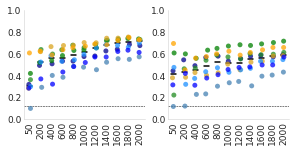

In [283]:


save=False


############################################################################################################

save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'
version = '20221012_v1'



############################################################################################################

ytick_length = 2
ytick_pad = 0.5
fontsize=9

sns.set_style("whitegrid", {'axes.grid' : False})
species_color_dict = {'BW':'darkblue',
              'NB': 'dodgerblue',
              'BK': 'steelblue',
              'SW': 'blue',
              'PO': 'orange',
              'LO': 'goldenrod',
              'GO': 'green',
              'LL': 'forestgreen',
              'MU': 'mediumspringgreen', 
              'MZ': 'turquoise'}

fig, ax = plt.subplots(ncols=2, 
                       nrows=1, 
                       constrained_layout=True, 
                       sharey=False, figsize = [4,2])


evaluation_df = evaluation_df.loc[evaluation_df['species'].isin(species_list)]
evaluation_df = evaluation_df.reset_index(drop=True)
metric = 'f1-score'

sns.stripplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df.loc[evaluation_df['voc_type']=='cry'],
                     hue='species', 
                     palette=species_color_dict, 
                     ax=ax[0], alpha=.75, s=5)

sns.stripplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df.loc[evaluation_df['voc_type']=='whistle'],
                     hue='species', 
                     palette=species_color_dict, 
                     ax=ax[1], alpha=.75, s=5)


sns.boxplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df.loc[evaluation_df['voc_type']=='cry'], 
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .1, "color":'black', 'alpha':0},
                whiskerprops={"linewidth": .1, "color":'black', 'alpha':0},
                width = .5, 
                showcaps=False,
                ax=ax[0])

sns.boxplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df.loc[evaluation_df['voc_type']=='whistle'], 
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .1, "color":'black', 'alpha':0},
                whiskerprops={"linewidth": .1, "color":'black', 'alpha':0},
                width = .5, 
                showcaps=False,
                ax=ax[1])

for i in [0,1]:
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_ylim([0,1])
    ax[i].legend([],[], frameon=False)
    
    ax[i].xaxis.set_tick_params(width=.5, rotation = 90, length = ytick_length, pad = ytick_pad)
    ax[i].yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)
    
    ax[i].set_yticks([0,.2, .4, .6, .8, 1])
    ax[i].set_ylim([0,1])
    ax[i].axhline(y=(1/8), linestyle= 'dashed', color='black', linewidth=0.5)


    for axis in ['top','bottom','left','right']:
            ax[i].spines[axis].set_linewidth(.5)
    for label in (ax[i].get_yticklabels() + ax[i].get_xticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(fontsize)

sns.despine()

if save:
    save_name = ('_').join(['f1-scores_by_sample_size', version])
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')
    

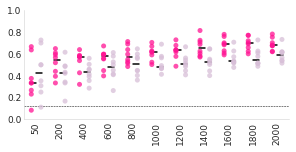

In [391]:


save=True


############################################################################################################

save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'
version = '20221012_v1'


############################################################################################################

ytick_length = 2
ytick_pad = 0.5
fontsize=9

voc_name_color_dict = {'cry': 'deeppink', 
               'whistle': 'thistle', 
               'nan':'black'}


sns.set_style("whitegrid", {'axes.grid' : False})
species_color_dict = {'BW':'darkblue',
              'NB': 'dodgerblue',
              'BK': 'steelblue',
              'SW': 'blue',
              'PO': 'orange',
              'LO': 'goldenrod',
              'GO': 'green',
              'LL': 'forestgreen',
              'MU': 'mediumspringgreen', 
              'MZ': 'turquoise'}

fig, ax = plt.subplots(ncols=1, 
                       nrows=1, 
                       constrained_layout=True, 
                       sharey=False, figsize = [4,2])


model_df = evaluation_df.loc[model_df['species'].isin(species_list)]
model_df = evaluation_df.reset_index(drop=True)
metric = 'precision'

sns.stripplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df,
                     jitter=False,
                     dodge=True,
                     hue='voc_type', 
                     palette=voc_name_color_dict, 
                     ax=ax, alpha=.75, s=5)

sns.boxplot(x='sample_size', 
                     y=metric, 
                     data=evaluation_df, 
                     hue='voc_type',
                dodge=True,
                whis=1.5, 
                showfliers = False, 
                flierprops={"marker": ""},
                medianprops={"color": "black"},
                boxprops={"linewidth": .1, "color":'black', 'alpha':0},
                whiskerprops={"linewidth": .1, "color":'black', 'alpha':0},
                width = .5, 
                showcaps=False,
                ax=ax)




ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim([0,1])
ax.legend([],[], frameon=False)

ax.xaxis.set_tick_params(width=.5, rotation = 90, length = ytick_length, pad = ytick_pad)
ax.yaxis.set_tick_params(width=.5, rotation = 0, length = ytick_length, pad = ytick_pad)

ax.set_yticks([0,.2, .4, .6, .8, 1])
ax.set_ylim([0,1])
ax.axhline(y=(1/8), linestyle= 'dashed', color='black', linewidth=0.5)


for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(.5)
for label in (ax.get_yticklabels() + ax.get_xticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(fontsize)

sns.despine()

if save:
    save_name = ('_').join(['precision_by_sample_size', version])
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')
    evaluation_df.to_csv(os.path.join(save_dir, 'training_set_comparison_evaluation.csv'), index=False)
    importances_df.to_csv(os.path.join(save_dir, 'training_set_comparison_importances.csv'), index=False)
    

In [379]:
cry_importances_df = importances_df.loc[importances_df['voc_type'] == 'cry']
cry_importances_df.index = cry_importances_df['sample_size']

whistle_importances_df = importances_df.loc[importances_df['voc_type'] == 'whistle']
whistle_importances_df.index = whistle_importances_df['sample_size']


cry_temp = cry_importances_df[[i for i in cry_importances_df.columns if '_mean' in i]]
cry_temp = cry_temp.transpose()
cry_temp.columns = [str(i) for i in sample_sizes]
top_importances = []
for sample_size in cry_temp.columns:
    temp_sorted = cry_temp.sort_values(by=[sample_size], ascending=False).index
    top_importances.append(list(temp_sorted))

cry_top_importances_df = pd.DataFrame(top_importances)
cry_top_importances_df.index = temp.columns

whis_temp = whistle_importances_df[[i for i in whistle_importances_df.columns if '_mean' in i]]
whis_temp = whis_temp.transpose()
whis_temp.columns = [str(i) for i in sample_sizes]
top_importances = []
for sample_size in whis_temp.columns:
    temp_sorted = whis_temp.sort_values(by=[sample_size], ascending=False).index
    top_importances.append(list(temp_sorted))
    
whistle_top_importances_df = pd.DataFrame(top_importances)
whistle_top_importances_df.index = temp.columns

In [380]:
to_plot = whis_temp.sort_values(by=[sample_size], ascending=False)

In [354]:
cry_top_importances_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
50,freq.Q25_mean,meandom_mean,freq.IQR_mean,time.Q75_mean,freq.Q75_mean,sp.ent_mean,dfslope_mean,time.Q25_mean,time.IQR_mean,freq.median_mean,time.median_mean,duration_mean,meanfreq_mean,time.ent_mean
200,freq.Q25_mean,sp.ent_mean,dfslope_mean,meandom_mean,time.median_mean,time.Q75_mean,meanfreq_mean,duration_mean,time.Q25_mean,freq.median_mean,time.IQR_mean,time.ent_mean,freq.Q75_mean,freq.IQR_mean
400,freq.Q25_mean,dfslope_mean,meanfreq_mean,sp.ent_mean,freq.IQR_mean,meandom_mean,time.ent_mean,duration_mean,time.median_mean,time.Q25_mean,time.Q75_mean,time.IQR_mean,freq.Q75_mean,freq.median_mean
600,freq.Q25_mean,sp.ent_mean,meanfreq_mean,dfslope_mean,time.IQR_mean,time.Q75_mean,freq.IQR_mean,meandom_mean,freq.Q75_mean,time.Q25_mean,duration_mean,freq.median_mean,time.median_mean,time.ent_mean
800,freq.Q25_mean,sp.ent_mean,dfslope_mean,meanfreq_mean,freq.median_mean,duration_mean,meandom_mean,freq.Q75_mean,time.Q25_mean,time.median_mean,time.ent_mean,time.IQR_mean,freq.IQR_mean,time.Q75_mean
1000,freq.Q25_mean,sp.ent_mean,meanfreq_mean,dfslope_mean,meandom_mean,freq.Q75_mean,freq.IQR_mean,freq.median_mean,duration_mean,time.median_mean,time.Q25_mean,time.IQR_mean,time.Q75_mean,time.ent_mean
1200,freq.Q25_mean,sp.ent_mean,dfslope_mean,meanfreq_mean,time.Q75_mean,time.IQR_mean,meandom_mean,time.median_mean,freq.Q75_mean,time.Q25_mean,duration_mean,freq.median_mean,freq.IQR_mean,time.ent_mean
1400,freq.Q25_mean,sp.ent_mean,dfslope_mean,meanfreq_mean,time.IQR_mean,freq.Q75_mean,duration_mean,freq.median_mean,meandom_mean,freq.IQR_mean,time.ent_mean,time.median_mean,time.Q75_mean,time.Q25_mean
1600,freq.Q25_mean,sp.ent_mean,dfslope_mean,meanfreq_mean,duration_mean,meandom_mean,freq.median_mean,time.IQR_mean,time.ent_mean,freq.Q75_mean,freq.IQR_mean,time.median_mean,time.Q75_mean,time.Q25_mean
1800,freq.Q25_mean,sp.ent_mean,dfslope_mean,meanfreq_mean,meandom_mean,duration_mean,time.IQR_mean,freq.median_mean,time.Q75_mean,freq.Q75_mean,freq.IQR_mean,time.median_mean,time.ent_mean,time.Q25_mean


In [355]:
whistle_top_importances_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
50,freq.Q25_mean,freq.median_mean,meandom_mean,time.Q25_mean,freq.Q75_mean,meanfreq_mean,freq.IQR_mean,dfslope_mean,sp.ent_mean,duration_mean,time.ent_mean,time.Q75_mean,time.median_mean,time.IQR_mean
200,freq.median_mean,freq.Q75_mean,meandom_mean,meanfreq_mean,time.ent_mean,sp.ent_mean,time.Q25_mean,dfslope_mean,duration_mean,time.IQR_mean,freq.Q25_mean,time.Q75_mean,time.median_mean,freq.IQR_mean
400,freq.median_mean,meandom_mean,time.ent_mean,meanfreq_mean,dfslope_mean,freq.Q25_mean,time.Q25_mean,sp.ent_mean,time.IQR_mean,time.median_mean,freq.Q75_mean,freq.IQR_mean,time.Q75_mean,duration_mean
600,freq.median_mean,meandom_mean,freq.Q25_mean,meanfreq_mean,time.ent_mean,sp.ent_mean,dfslope_mean,time.Q25_mean,time.IQR_mean,freq.Q75_mean,duration_mean,time.Q75_mean,time.median_mean,freq.IQR_mean
800,freq.median_mean,meanfreq_mean,freq.Q25_mean,meandom_mean,sp.ent_mean,dfslope_mean,time.ent_mean,time.Q25_mean,freq.Q75_mean,freq.IQR_mean,time.median_mean,time.IQR_mean,duration_mean,time.Q75_mean
1000,meandom_mean,meanfreq_mean,freq.median_mean,sp.ent_mean,freq.Q25_mean,dfslope_mean,time.Q25_mean,time.ent_mean,freq.Q75_mean,time.median_mean,freq.IQR_mean,time.Q75_mean,time.IQR_mean,duration_mean
1200,meandom_mean,meanfreq_mean,freq.Q25_mean,freq.median_mean,sp.ent_mean,dfslope_mean,time.Q25_mean,time.ent_mean,freq.Q75_mean,freq.IQR_mean,time.IQR_mean,duration_mean,time.Q75_mean,time.median_mean
1400,meandom_mean,freq.median_mean,freq.Q25_mean,meanfreq_mean,sp.ent_mean,dfslope_mean,time.Q25_mean,time.ent_mean,freq.Q75_mean,time.median_mean,time.IQR_mean,freq.IQR_mean,duration_mean,time.Q75_mean
1600,sp.ent_mean,meanfreq_mean,meandom_mean,freq.median_mean,freq.Q25_mean,dfslope_mean,time.ent_mean,time.Q25_mean,freq.Q75_mean,duration_mean,freq.IQR_mean,time.IQR_mean,time.median_mean,time.Q75_mean
1800,meandom_mean,sp.ent_mean,meanfreq_mean,freq.Q25_mean,freq.median_mean,dfslope_mean,time.ent_mean,time.Q25_mean,freq.Q75_mean,freq.IQR_mean,time.IQR_mean,duration_mean,time.median_mean,time.Q75_mean


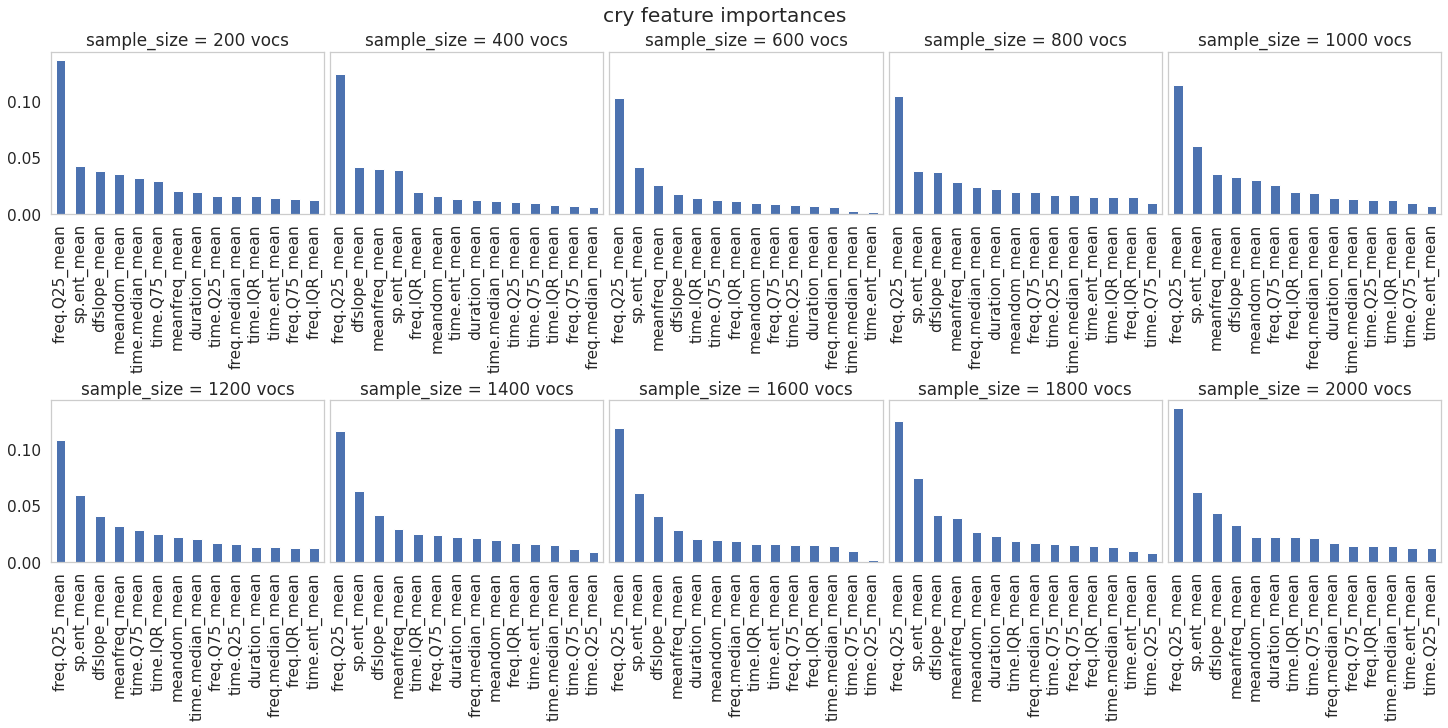

In [389]:

save = False

voc_type = 'cry'

############################################################################################################

if voc_type == 'cry':
    temp = cry_temp
elif voc_type == 'whistle':
    temp = whis_temp
    
save_dir = '/n/hoekstra_lab_tier1/Users/njourjine/manuscript/figures/figure_2/'
version = '20221012_v1'

# plot
fig, ax = plt.subplots(nrows=2, ncols=5, figsize = [20,10], constrained_layout=True, sharey=True)

plt.suptitle(voc_type+' feature importances')

to_plot = temp.sort_values(by=['200'], ascending=False)
to_plot['200'].plot.bar(ax=ax[0,0])
ax[0,0].set_title('sample_size = 200 vocs')

to_plot = temp.sort_values(by=['400'], ascending=False)
to_plot['400'].plot.bar(ax=ax[0,1])
ax[0,1].set_title('sample_size = 400 vocs')

to_plot = temp.sort_values(by=['600'], ascending=False)
to_plot['600'].plot.bar(ax=ax[0,2])
ax[0,2].set_title('sample_size = 600 vocs')

to_plot = temp.sort_values(by=['800'], ascending=False)
to_plot['800'].plot.bar(ax=ax[0,3])
ax[0,3].set_title('sample_size = 800 vocs')

to_plot = temp.sort_values(by=['1000'], ascending=False)
to_plot['1000'].plot.bar(ax=ax[0,4])
ax[0,4].set_title('sample_size = 1000 vocs')

to_plot = temp.sort_values(by=['1200'], ascending=False)
to_plot['1200'].plot.bar(ax=ax[1,0])
ax[1,0].set_title('sample_size = 1200 vocs')

to_plot = temp.sort_values(by=['1400'], ascending=False)
to_plot['1400'].plot.bar(ax=ax[1,1])
ax[1,1].set_title('sample_size = 1400 vocs')

to_plot = temp.sort_values(by=['1600'], ascending=False)
to_plot['1600'].plot.bar(ax=ax[1,2])
ax[1,2].set_title('sample_size = 1600 vocs')

to_plot = temp.sort_values(by=['1800'], ascending=False)
to_plot['1800'].plot.bar(ax=ax[1,3])
ax[1,3].set_title('sample_size = 1800 vocs')

to_plot = temp.sort_values(by=['2000'], ascending=False)
to_plot['2000'].plot.bar(ax=ax[1,4])
ax[1,4].set_title('sample_size = 2000 vocs')

if save:
    save_name = ('_').join([voc_type,'feature_importances_by_training_set_size', version])
    plt.savefig(os.path.join(save_dir, save_name)+'.jpeg', dpi=600)
    plt.savefig(os.path.join(save_dir, save_name)+'.svg')